# Проект: Исследование влияния изменения шрифта в приложении по продаже продуктов питания на конверсию в воронке продаж

### 1. Описание проекта

**Цель проекта:** Выяснить, повлияет ли изменение шрифтов во всем приложении по продаже продуктов питания на конверсию.\
**Задачи:**
- Изучить воронку продаж приложения, выявить узкие места.
- Исследовать результаты А/А/В эксперимента по изменению шрифта.

**Данные:**\
logs_exp.csv - лог действий и событий в рамках А/А/В теста.

**План анализа:**
1) Подготовка данных: нормализуем названия столбцов, работаем с дубликатами и пропусками.\
2) Исследовательский анализ данных: рассмотрим сроки проведения эксперимента, число зафиксированных событий и пользователей.\
3) Проанализируем воронку событий, найдем узкие места, где теряется больше всего пользователей.\
4) Проанализируем результаты А/А/Б теста: сначала сравним А/А группы для проверки корректности разделения пользователей, а затем, в случае положительно результата, сравним тестовую группу с объединенной контрольной.

### 2. Подготовка данных

In [1]:
# Импортируем библиотеки, которые будем в дальнейшем использовать в работе
import pandas as pd
from pandas.plotting import register_matplotlib_converters

import datetime as dt

import seaborn as sns

from matplotlib import pyplot as plt
from matplotlib.pyplot import figure

import numpy as np

from scipy import stats as st
import math as mth

#### 2.1. Загрузим данные и сделаем предобработку

In [2]:
# Загрузим логи в переменную
logs = pd.read_csv('/datasets/logs_exp.csv', sep='\t')  

In [3]:
logs.head(5)

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


In [4]:
# Рассмотрим инфо по таблице, чтобы увидеть названия столбцов и наличие пропусков
logs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


Пропусков в данных не обнаружили.\
Приведем названия столбцов к нижнему регистру и изменим тип данных у столбца времени события.

In [5]:
# Нормализуем названия столбцов
logs = logs.rename(columns={"EventName": "event_name", "DeviceIDHash": "device_id_hash", "EventTimestamp": "event_timestamp", "ExpId" : "exp_id"})

In [6]:
# Изменим тип даты и времени с юниксового
logs['event_timestamp'] = pd.to_datetime(logs['event_timestamp'], unit = 's')

In [7]:
# Проверим нет ли полных дубликатов
logs.duplicated().sum()

413

Обнаружили 413 полностью дублицированных строк (менее 1% от массива), удалим их.

In [8]:
logs = logs.drop_duplicates()

In [9]:
# Проверим нормализацию названий столбцов и очистку дубликатов
logs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 243713 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   event_name       243713 non-null  object        
 1   device_id_hash   243713 non-null  int64         
 2   event_timestamp  243713 non-null  datetime64[ns]
 3   exp_id           243713 non-null  int64         
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 9.3+ MB


Добавим отдельный столбец с датами

In [10]:
logs['event_date'] = pd.to_datetime(logs['event_timestamp']).dt.date

In [11]:
logs.head(5)

,event_name,device_id_hash,event_timestamp,exp_id,event_date
0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36,246,2019-07-25
1,MainScreenAppear,7416695313311560658,2019-07-25 11:11:42,246,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
3,CartScreenAppear,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,2019-07-25 11:48:42,248,2019-07-25


Врамках предобработки данных мы:
- нормализовали формат названий столбцов,
- конвертировали время событий из юниксового в datetime,
- удалили полные дубликаты,
- добавили столбец с датами событий.

### 3. Изучим и проверим данные

#### 3.1. Число событий и пользователей

In [12]:
# Посчитаем количество событий
logs.shape

(243713, 5)

In [13]:
# Посчитаем количество уникальных пользователей
logs['device_id_hash'].nunique()

7551

In [14]:
# Рассмотрим, сколько в среднем событий приходится на пользователя
logs.groupby('device_id_hash')['event_timestamp'].count().mean()

32.27559263673685

В среднем одного на пользователя приходится 32 события.

#### 3.2. Период наблюдения

In [15]:
# Разберемся, какой период мы имеем, найдем минимальную и максимальную дату
print(min(logs['event_timestamp']))
print(max(logs['event_timestamp']))
(max(logs['event_timestamp']) - min(logs['event_timestamp'])).days

2019-07-25 04:43:36
2019-08-07 21:15:17


13

Дата самого раннего события - 25 июля 2019 г, дата самого позднего - 7 августа 2019 года. Эксперимент длился 13 дней.

Построим гистограмму, чтобы сравнить полноту данных по дням. 

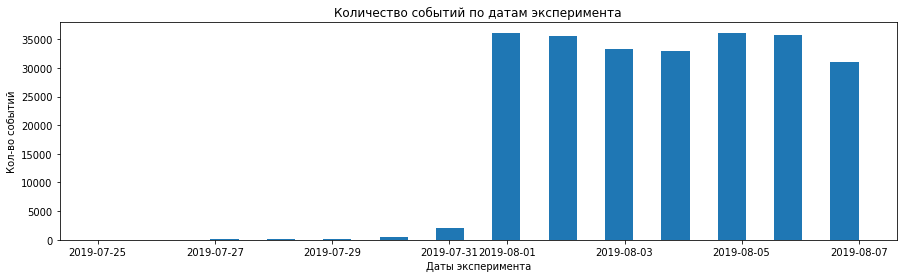

In [16]:
plt.figure(figsize=(15,4))
plt.title('Количество событий по датам эксперимента')
plt.ylabel('Кол-во событий')
plt.xlabel('Даты эксперимента')
logs['event_date'].hist(bins=27)
plt.grid(visible=False)
plt.show()

По гистограмме видно, что в июльские дни данных значительно меньше, чем в августе.\
Попробуем отбросить данные за эти дни, чтобы не искажать статистику.

In [17]:
# Оставим только данные с 1 августа
logs_clean = logs[logs['event_date']>=dt.date(2019, 8, 1)]

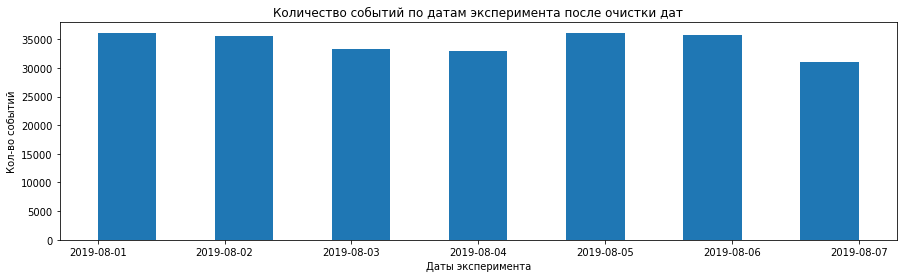

In [18]:
plt.figure(figsize=(15,4))
plt.title('Количество событий по датам эксперимента после очистки дат')
plt.ylabel('Кол-во событий')
plt.xlabel('Даты эксперимента')
logs_clean['event_date'].hist(bins=13)
plt.grid(visible=False)
plt.show()

#### 3.3. Проверка данных после отсечения июля

Посмотрим, что мы потеряли, после урезания периода 

In [19]:
# Посчитаем количество уникальных пользователей и посмотрим, сколько мы потеряли после отсечения
print("Пользователей после очистки:",logs_clean['device_id_hash'].nunique())
print("Потеряли пользователей, чел.:",logs['device_id_hash'].nunique() - logs_clean['device_id_hash'].nunique())
print("Доля потерянных пользователей:",
      "{:.2%}".format((logs['device_id_hash'].nunique() - logs_clean['device_id_hash'].nunique())
                      /logs_clean['device_id_hash'].nunique()))

Пользователей после очистки: 7534
Потеряли пользователей, чел.: 17
Доля потерянных пользователей: 0.23%


In [20]:
print("Событий после очистки:",len(logs_clean.index))
print("Потеряли событий, шт.:",len(logs.index) - len(logs_clean.index))
print("Доля потерянных событий:",
      "{:.2%}".format((len(logs.index) - len(logs_clean.index))
                      /len(logs.index)))

Событий после очистки: 240887
Потеряли событий, шт.: 2826
Доля потерянных событий: 1.16%


Итак, мы потеряли данные о 0,2% пользователей и 1% событий - выглядит незначительно.

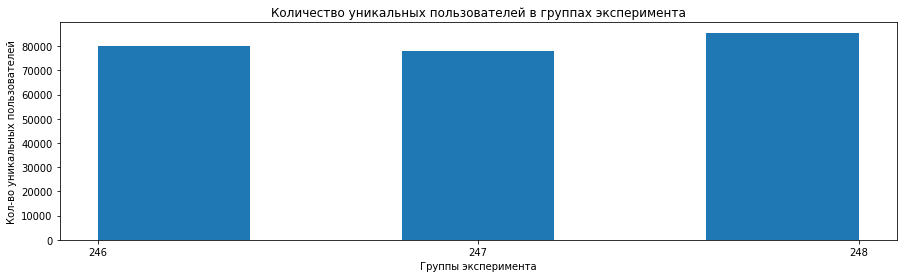

In [21]:
plt.figure(figsize=(15,4))
plt.title('Количество уникальных пользователей в группах эксперимента')
plt.ylabel('Кол-во уникальных пользователей')
plt.xlabel('Группы эксперимента')
logs['exp_id'].hist(bins=5)
plt.xticks(np.arange(246, 249, 1))
plt.grid(visible=False)
plt.show()

Мы по-прежнему располагаем данными из всех трех групп эксперимента и количество событий распределено между группами равномерно.

**Мы установили, что у нас есть 7 полноценных, с точки зрения полноты данных, дней эксперимента: с 1 по 7 августа 2019 года.**

### 4. Анализ воронки событий, определение узких мест

#### 4.1. Типы событий в логах

In [22]:
# Изучим, какие события есть в логах
logs_clean['event_name'].unique()

array(['Tutorial', 'MainScreenAppear', 'OffersScreenAppear',
       'CartScreenAppear', 'PaymentScreenSuccessful'], dtype=object)

События в том порядке, в котором, предполагаем, по сценарию их проходит пользователь:
1. Tutorial - пользователь видит инструкцию к приложению.
2. MainScreenAppear - пользователю отображается главный экран приложения.
3. OffersScreenAppear - пользователю отображается каталог товаров.
4. CartScreenAppear - пользователю отображается страница с  содержимым корзины.
5. PaymentScreenSuccessful - пользователь видит экран успешной оплаты.

Сходу есть сомнения в том, что Tutorial - это обязательное событие, через которое проходит каждый пользователь. Остальные пункты кажутся необходимыми для совершения оплаты. Посмотрим на данных.

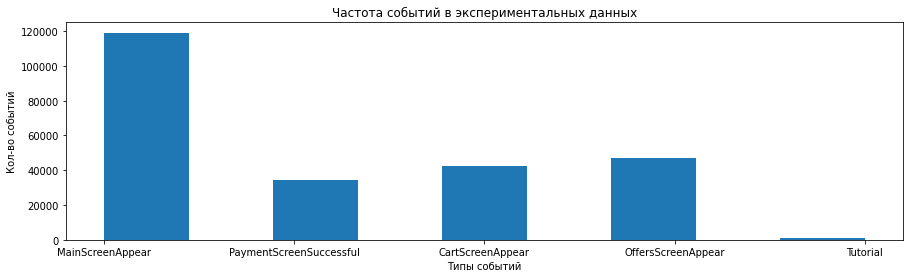

In [23]:
# Посмотрим частоту событий по типам
plt.figure(figsize=(15,4))
plt.title('Частота событий в экспериментальных данных')
plt.ylabel('Кол-во событий')
plt.xlabel('Типы событий')
logs['event_name'].hist(bins=9)
plt.grid(visible=False)
plt.show()

Да, Tutorial явно не обязательное событие. Предполагаю, что это справка, которую пользователи могут вызвать в любой момент. Остальные события по частоте совершений вполне укладываются в логику воронки.\
Здесь же сразу можно предположить, что узким местом является переход с главного экрана в каталог - туда переходят в два раза реже, чем заходят на главный экран.

In [24]:
# Посчитаем, сколько уникальных пользователей совершило событие каждого типа
grouped_data = logs_clean.groupby('event_name')['device_id_hash'].nunique().reset_index().sort_values(by='device_id_hash',ascending=False)
grouped_data['percent_from_total'] = round(grouped_data['device_id_hash'] / logs_clean['device_id_hash'].nunique(),3)
grouped_data

,event_name,device_id_hash,percent_from_total
1,MainScreenAppear,7419,0.985
2,OffersScreenAppear,4593,0.610
0,CartScreenAppear,3734,0.496
3,PaymentScreenSuccessful,3539,0.470
4,Tutorial,840,0.111


Видим, что мы теряем почти 40% пользователей на переходе с главного экрана к каталогу.

In [25]:
# Удалим события с типом Tutorial, потому что они не укладываются в воронку покупки
logs_clean = logs_clean[logs_clean['event_name'] != 'Tutorial']

#### 4.2. Определение узких мест в воронке

Посчитаем конверсию на разных этапах воронки

In [26]:
grouped_data = logs_clean.groupby('event_name')['device_id_hash'].nunique().reset_index().sort_values(by='device_id_hash',ascending=False)
grouped_data['percent_from_total'] = round(grouped_data['device_id_hash'] / logs_clean['device_id_hash'].nunique(),3)

In [27]:
grouped_data['conversion_from_previous'] = round(grouped_data['device_id_hash'] / grouped_data['device_id_hash'].shift(1),3)

In [28]:
grouped_data

,event_name,device_id_hash,percent_from_total,conversion_from_previous
1,MainScreenAppear,7419,0.985,NaN
2,OffersScreenAppear,4593,0.610,0.619
0,CartScreenAppear,3734,0.496,0.813
3,PaymentScreenSuccessful,3539,0.470,0.948


Лучшая конверсия при переходе от корзины к экрану успешной оплаты - 94%.\
Худшая - при переходе от основного экрана к каталогу - 60%. Улучшение конверсии на этом шаге должно дать наибольший эффект для повышения продаж.

Всего покупку совершает 46% всех пользователей приложения (доля тех, кто видит экран успешной оплаты). Много ли это? Кажется, что для приложения, основная функция которого покупать продукты, немного. Быстро найти референсные значения в интернете, к сожалению, не удалосью

### 5. Анализ результатов эксперимента

In [30]:
# Проверим пользователей, которые могли участвовать в двух или нескольких группах одновременно:
logs_clean.groupby('device_id_hash').agg({'exp_id':'nunique'}).query('exp_id > 1') 

,exp_id
device_id_hash,


Пользователей, попавших больше, чем в одну группу, нет.

In [31]:
# Посмотрим, сколько пользователей эксперимента в каждой экспериментальной группе
logs_clean.groupby('exp_id')['device_id_hash'].nunique()

exp_id
246    2483
247    2512
248    2535
Name: device_id_hash, dtype: int64

Еще раз отметим равномерное распределение пользователей между группами

#### 5.1. Разработаем функцию для проверки гипотезы о равенстве доли пользователей с каждым событием в контрольных группах

Разработаем функцию, которая будет принимать на вход параметры:
- logs - датасет с логами эксперимента,
- alpha - уровень статистической значимости,
- group_a - идентификатор первой тестовой группы,
- group_b - идентификатор второй тестовой группы.

На выходе функция будет выдавать p-value и результаты проверки гипотез для всех уникальных событий в датасете.

In [32]:
def stage_test (logs, alpha, group_a, group_b):   
    #Расчитаем кол-во пользователей на верхнем этапе воронки
    enter_users_a = logs.query('exp_id == @group_a')['device_id_hash'].nunique()
    enter_users_b = logs.query('exp_id == @group_b')['device_id_hash'].nunique()
    
    #Собираем названия этапов и сортируем по убыванию числа пользователей
    stages = logs.groupby('event_name')['device_id_hash'].nunique().reset_index().sort_values(by='device_id_hash',ascending=False)
    stages['row_num'] = np.arange(len(stages))
    
    from termcolor import colored
    
    i = 1 # Добавляем счетчик для заголовков
    
    for stage in stages['event_name']:
        # Расчитываем количество пользователей на "выходном" этапе воронке по группам
        out_users_a = logs.query('exp_id == @group_a & event_name == @stage')['device_id_hash'].nunique()
        out_users_b = logs.query('exp_id == @group_b & event_name == @stage')['device_id_hash'].nunique()

        # Расчитываем конверсию для каждой группы
        c_a = out_users_a / enter_users_a
        c_b = out_users_b / enter_users_b

        # Считаем разницу пропорций в группах
        c_diff = c_a - c_b

        # Расчитываем конверсию для комбинированной группы
        c_comb = (out_users_a + out_users_b) / (enter_users_a + enter_users_b)

        # Считаем статистику в стандартных отклонениях стандартного нормаcvльного распределения
        z_value = c_diff / mth.sqrt(c_comb * (1 - c_comb) * (1/enter_users_a + 1/enter_users_b))

        # Задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
        distr = st.norm(0, 1)  

        # Расчитываем p-value
        p_value = (1 - distr.cdf(abs(z_value))) * 2
        
        #Выводим результат сравнения
        print(colored(i, 'blue', attrs=['bold']), 
              colored(') Этап ', 'blue', attrs=['bold']),
              colored(stage, 'blue', attrs=['bold']),
              colored(', группы ', 'blue', attrs=['bold']),
              colored(group_a, 'blue', attrs=['bold']),
              colored(' и ', 'blue', attrs=['bold']),
              colored(group_b, 'blue', attrs=['bold']),              
              colored(': поиск статистически значимых отличий в доле пользователей c событием', 'blue', attrs=['bold'])
              , sep='')
               
        print()
        
        print('Доля пользователей с событием',stage,'составила:')
        print('  - в группе ', group_a, ': ', "{:.2%}".format(c_a), sep='')
        print('  - в группе ', group_b, ': ', "{:.2%}".format(c_b), sep='')
        print()
        
        print('p-значение: ', round(p_value,3))
        print()
        
        print(colored('Вывод:', attrs=['bold']))
        if p_value < alpha:
            print('Отвергаем нулевую гипотезу: между конверсиями есть значимая разница.')
        else:
            print(
                'Не получилось отвергнуть нулевую гипотезу, нет оснований считать конверсии разными.'
            ) 
        print()
        print()
        
        i +=1

#### 5.2. Проверка корректности эксперимента - А/А тест

С помощью функции stage_test **проверим наличие статистически значимых различий** между контрольными группами для события каждого типа.

**Уровень статистической значимости** для каждого отдельного эксперимента я бы принял равным 0.05. Однако, мы собираемся сделать множественный тест - сделать 4 проверки для контрольных выборок, и в случае успеха, ещё 4 проверки для сравнения групп А и В.\
Применим поправка Бонферрони и рассчитаем **уровень стат. значимости = 0.05 / 8 = 0.00625**

Гипотезы для всех этапов сформулируем так:\
Н0: Доля пользователей, имеющих данный тип события от всех пользователей в выборке для группы 246 **не отличается** от доли таких пользователей для группы 247.\
Н1: Доля пользователей, имеющих данный тип события от всех пользователей в выборке для группы 246 **отличается** от доли таких пользователей для группы 247.

In [33]:
alpha = 0.00625 #Задаем уровень статистической значимости
group_a = 246  # Задаем идентификаторы сравниваемых групп
group_b = 247
stage_test(logs_clean, alpha, group_a, group_b)

1) Этап MainScreenAppear, группы 246 и 247: поиск статистически значимых отличий в доле пользователей c событием

Доля пользователей с событием MainScreenAppear составила:
  - в группе 246: 98.67%
  - в группе 247: 98.57%

p-значение:  0.753

Вывод:
Не получилось отвергнуть нулевую гипотезу, нет оснований считать конверсии разными.


2) Этап OffersScreenAppear, группы 246 и 247: поиск статистически значимых отличий в доле пользователей c событием

Доля пользователей с событием OffersScreenAppear составила:
  - в группе 246: 62.10%
  - в группе 247: 60.51%

p-значение:  0.248

Вывод:
Не получилось отвергнуть нулевую гипотезу, нет оснований считать конверсии разными.


3) Этап CartScreenAppear, группы 246 и 247: поиск статистически значимых отличий в доле пользователей c событием

Доля пользователей с событием CartScreenAppear составила:
  - в группе 246: 50.99%
  - в группе 247: 49.28%

p-значение:  0.229

Вывод:
Не получилось отвергнуть нулевую гипотезу, нет оснований считать конверсии

Мы не обнаружили статистически значимых отличий между конверсиями контрольных групп для каждого из этапов воронки, значит контрольная группа сформирована корректно.

Объеденим контрольные группы 246 и 247 в одну для сравнения с группой 248. Для этого присвоим обеим группам общий идентификатор 246.

In [34]:
#На всякий случай произведем объединение выборок в новом датафрейме logs_u
logs_u = logs_clean
logs_u['exp_id'] = logs_u['exp_id'].replace(247,246)

In [35]:
logs_u.groupby('exp_id')['device_id_hash'].nunique()

exp_id
246    4995
248    2535
Name: device_id_hash, dtype: int64

#### 5.3. Сравнение конверсии в группах А и В

С помощью функции conversion_test проверим наличие статистически значимых различий между группами А и В на каждом этапе эксперимента.

Уровень статистической значимости для всех этапов примем равным 0.00625 - с учетом поправки Бонферрони, о которой мы писали в п. 5.2.

Гипотезы для всех этапов сформулируем так:\
Н0: Доля пользователей, имеющих данный тип события от всех пользователей в выборке для объединенной группы А **не отличается** от доли таких пользователей для группы B.\
Н1: Доля пользователей, имеющих данный тип события от всех пользователей в выборке для объединенной группы А **отличается** от доли таких пользователей для группы B.

In [36]:
alpha = 0.00625 #Задаем уровень статистической значимости
group_a = 246  # Задаем идентификаторы сравниваемых групп
group_b = 248
stage_test(logs_u, alpha, group_a, group_b)

1) Этап MainScreenAppear, группы 246 и 248: поиск статистически значимых отличий в доле пользователей c событием

Доля пользователей с событием MainScreenAppear составила:
  - в группе 246: 98.62%
  - в группе 248: 98.34%

p-значение:  0.349

Вывод:
Не получилось отвергнуть нулевую гипотезу, нет оснований считать конверсии разными.


2) Этап OffersScreenAppear, группы 246 и 248: поиск статистически значимых отличий в доле пользователей c событием

Доля пользователей с событием OffersScreenAppear составила:
  - в группе 246: 61.30%
  - в группе 248: 60.39%

p-значение:  0.446

Вывод:
Не получилось отвергнуть нулевую гипотезу, нет оснований считать конверсии разными.


3) Этап CartScreenAppear, группы 246 и 248: поиск статистически значимых отличий в доле пользователей c событием

Доля пользователей с событием CartScreenAppear составила:
  - в группе 246: 50.13%
  - в группе 248: 48.52%

p-значение:  0.187

Вывод:
Не получилось отвергнуть нулевую гипотезу, нет оснований считать конверсии

По результатам сравнения на каждом из этапов мы не обнаружили статистически значимых различий между группами по количеству пользователей с каждым из событий 

С одной стороны мы не видим осязаемых улучшений от изменения шрифта, поэтому стоит ли вкладывать в это ресурсы? С другой стороны мы убедились в том, что после изменения шрифта движение пользователей по воронке не ухудшится.

### 6. Общий вывод

Мы провели исследование с целью установить повлияет ли изменение шрифтов во всем приложении по продаже продуктов питания на конверсию.

**1 Подготовка данных**

В рамках подготовки данных мы:
- нормализовали формат названий столбцов,
- конвертировали время событий из юниксового в datetime,
- удалили полные дубликаты (413 строк - менее 1% от массива),
- добавили столбец с датами событий.


**2 Изучение и проверка данных**

Мы определили реальный период наблюдения: с 1 по 7 августа. Данные за предыдущие дни отбросили, т.к. они содержали значительно меньший объем событий: удалив данные за 6 дней мы потеряли записи всего 1% от всех событий и 17 пользователей.


**3 Анализ воронки событий**

3.1. Мы установили, что в логах присутствует информация о 5 типах событий:
1) MainScreenAppear - пользователю отображается главный экран приложения.\
2) OffersScreenAppear - пользователю отображается каталог товаров.\
3) CartScreenAppear - пользователю отображается страница с  содержимым корзины.\
4) PaymentScreenSuccessful - пользователь видит экран успешной оплаты.\
5) Tutorial - пользователь видит инструкцию к приложению.\
События с 1 по 4 являются этапами воронки в соответствующей последовательности.\
Мы пришли к выводу, что событие Tutorial не является этапом воронки и исключили его из датафрейма.\
Кроме того, мы исключили из датафрейма записи пользователей, у которых отсутствовал верх воронки (событие MainScreenAppear), чтобы они не искажали конверсию. Верхний этап воронки этих пользователей мы удалили в пункте 2, когда убирали лишние даты.

3.2. Мы обнаружили, что наибольшее число пользователей (40%) теряется на переходе от главного экрана к каталогу товаров (MainScreenAppear -> OffersScreenAppear). Таким образом для стоит сосредоточиться на улучшении конверсии этого этапа.


**4 Анализ результатов эксперимента**

4.1. Мы разработали функцию stage_test для проверки наличия статистически значимых различий между контрольными группами по доле пользователей с каждым из типов событий от общего числа пользователей.

4.2. Мы применили поправку Бонферрони, исходя из того, что проведём 8 сравнений на одном датасете, и рассчитали уровень статистистической значимости равным 0.00625.

4.3. Мы установили, что доля пользователей с каждым из типов событий не имеет статистически значимых отличий и пришли к выводу, что контрольная группа сформирована корректно. 

4.5. Мы долю пользователей с каждым из типов событий тестовой группы с соответствующими долями контрольной группы на каждом этапе и там тоже не обнаружили статистически значимое различий.

4.6. Отметим, что полученные p-value имеют такие значения, что даже применение более мягких поправок для уровня статистической значимости, не изменило бы результаты сравнений.

4.7. **С учетом полученных результатов мы можем сказать, что**
- Изменение шрифта в приложении скорее всего не окажет негативного влияния на продажи. Говоря по-простому, новые шрифты не мешают пользователям пользоваться приложением.
- Обнаружить статистически значимое улучшение удалось не удалось ни для одного из типов событий. То есть нет оснований говорить о том, что новые шрифты улучшат пользовательский опыт так, что повлияет на их движение по воронке.
- Таким образом мы не возражаем против изменения шрифтов, но и не ожидаем от них улучшений в продажах.